In [1]:
import torch
import numpy as np
import matplotlib
from alodataset import transforms as T
from alodataset import WaymoDataset, Split
from aloscene import BoundingBoxes3D, CameraIntrinsic, CameraExtrinsic, Frame

matplotlib.rcParams['figure.figsize'] = (20, 10)

We will use a sample of Waymo Open Dataset to demonstrate some basic usage of **BoundingBoxes3D**, **CameraIntrinsic**, **CameraExtrinsic** as well as the strengths of **aloscene** in data visualization and transformation.

In [2]:
waymo_dataset = WaymoDataset(sample=True)

WaymoDataset gives us a sequence of frames. For simplicity, we will use only one frame for this minimal example.

In [4]:
# in the 5th sequence, we get images from `front_left` camera
frames = waymo_dataset.get(5)["front_right"] 
print("Frame sequence", frames.shape, frames.names)
# get the first frame in sequence
frame = frames[0] 
print("Sliced frame", frame.shape, frame.names)

Frame sequence torch.Size([2, 3, 1280, 1920]) ('T', 'C', 'H', 'W')
Sliced frame torch.Size([3, 1280, 1920]) ('C', 'H', 'W')


`frame` contains camera calibrations to project bounding boxes 3D from 3D space onto image space. For more details, check **Camera Calibration** section in the documentation.

In [5]:
# Get boxes 3d, camera calibrations through frame
boxes_3d = frame.boxes3d["gt_boxes_3d"]
cam_intrinsic = frame.cam_intrinsic
cam_extrinsic = frame.cam_extrinsic

Once the `frame` is populated with boxes 3d and camera calibration (intrinsic and extrinsic), we can easily visualize boxes 3d: 

## Visualization

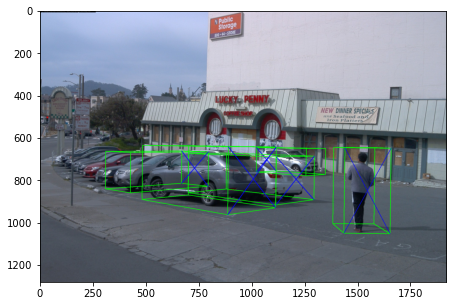

In [6]:
frame.get_view([frame.boxes3d]).render()

By default, `boxes_3d` will be display in 3D mode as above. We can also display the enclosing 2d boxes in mode 2D:

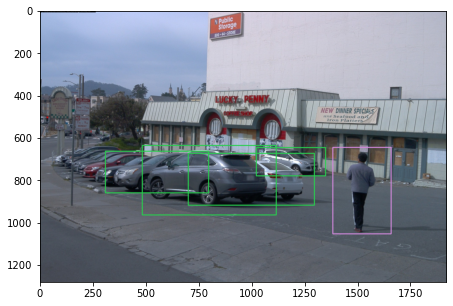

In [7]:
frame.get_view([frame.boxes3d], mode="2D").render()

If we wish to get those enclosing boxes on image as **BoundingBoxes2D**:

In [8]:
enclosing_boxes_2d = BoundingBoxes3D.get_enclosing_box_2d(
    boxes_3d, cam_intrinsic, cam_extrinsic, frame.HW)
print(type(enclosing_boxes_2d))

<class 'aloscene.bounding_boxes_2d.BoundingBoxes2D'>


## Transformation

Another advantage of **aloscene** is that we can transform frame and its labels easily. We will see in the example below how we can easily horizontal flip/crop an image with its boxes 3D with only 1 line of code. You can try for yourself with other transformation (see **Transformation** section in documentation).

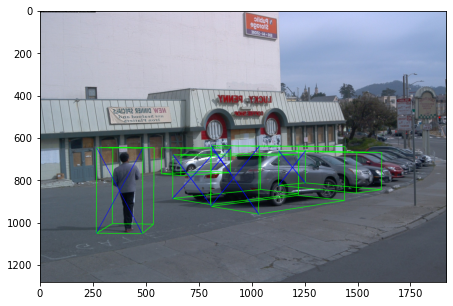

In [9]:
flipped_frame = frame.hflip()
flipped_frame.get_view([flipped_frame.boxes3d]).render()

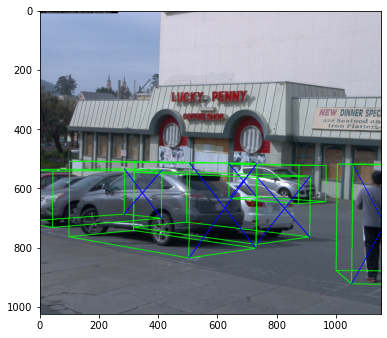

In [10]:
cropped_frame = frame.crop((0.1, 0.9), (0.2, 0.8))
cropped_frame.get_view([cropped_frame.boxes3d]).render()

## IoU / GIoU 3D

**BoundingBoxes3D** supports calculation of IoU/GIoU 3D between 2 set of boxes:

In [11]:
device = torch.device("cuda") # this calculation works only on GPU
boxes1 = BoundingBoxes3D(
    torch.tensor(
        [
            # [X, Y, Z, W, H, L, orientation]
            [150, 0, 150, 50, 10, 80, np.pi / 3],
            [100, 0, 200, 100, 10, 20, -np.pi / 12],
        ],
        device=device))

boxes2 = BoundingBoxes3D(
    torch.tensor(
        [
            [150, 5, 150, 50, 10, 80, 0], 
            [100, -3, 200, 100, 10, 20, np.pi / 2]
        ],
        device=device))

iou3d = boxes2.iou3d_with(boxes1)
giou3d = boxes2.giou3d_with(boxes1)
print(iou3d)
print(giou3d)

tensor([0.2178, 0.0781], device='cuda:0')
tensor([-0.2126, -0.5155], device='cuda:0')


## Other features

In [12]:
# Get vertices in 3D coordinates
vertices = BoundingBoxes3D.get_vertices_3d(boxes_3d)

# Get vertices projected on image
vertices_proj = BoundingBoxes3D.get_vertices_3d_proj(boxes_3d, cam_intrinsic, cam_extrinsic)

# Get enclosing 2d boxes on image
enclosing_boxes_2d = BoundingBoxes3D.get_enclosing_box_2d(boxes_3d, cam_intrinsic, cam_extrinsic, frame.HW)

# Get Bird Eye View boxes
bev_boxes = boxes_3d.bev_boxes()